Liczba dostępnych GPU: 1

 Uruchamianie GA z akceleracją GPU 
Pokolenie 0, najlepszy dystans: 36880.82
Pokolenie 20, najlepszy dystans: 28461.21
Pokolenie 40, najlepszy dystans: 23269.40
Pokolenie 60, najlepszy dystans: 21602.72
Pokolenie 80, najlepszy dystans: 20464.08
Pokolenie 100, najlepszy dystans: 19081.93
Pokolenie 120, najlepszy dystans: 18143.72
Pokolenie 140, najlepszy dystans: 17402.23
Pokolenie 160, najlepszy dystans: 17138.50
Pokolenie 180, najlepszy dystans: 16819.27
Pokolenie 200, najlepszy dystans: 16514.18
Pokolenie 220, najlepszy dystans: 16369.64
Pokolenie 240, najlepszy dystans: 16097.31
Pokolenie 260, najlepszy dystans: 15546.62
Pokolenie 280, najlepszy dystans: 15174.50

Najlepsza znaleziona trasa (pierwsze 10 miast): [73, 50, 51, 59, 72, 35, 5, 53, 8, 75]...
Dystans: 14914.52


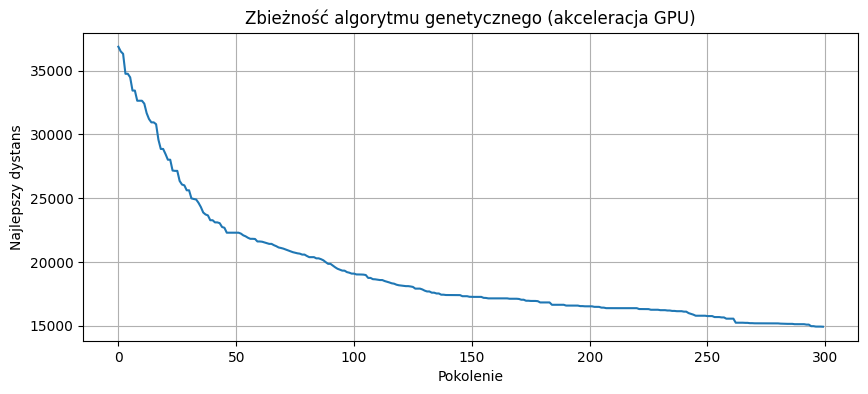


 Analiza wydajności CPU vs GPU

 Rozmiar problemu: 20 miast 
CPU: 0.0005 s, GPU: 0.0012 s, speedup: 0.38x

 Rozmiar problemu: 50 miast 
CPU: 0.0011 s, GPU: 0.0007 s, speedup: 1.57x

 Rozmiar problemu: 100 miast 
CPU: 0.0023 s, GPU: 0.0009 s, speedup: 2.65x

 Rozmiar problemu: 200 miast 
CPU: 0.0042 s, GPU: 0.0015 s, speedup: 2.89x


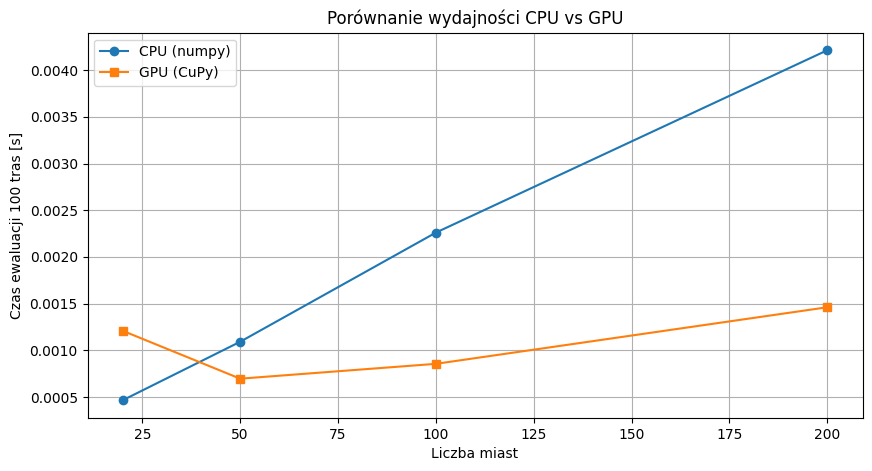

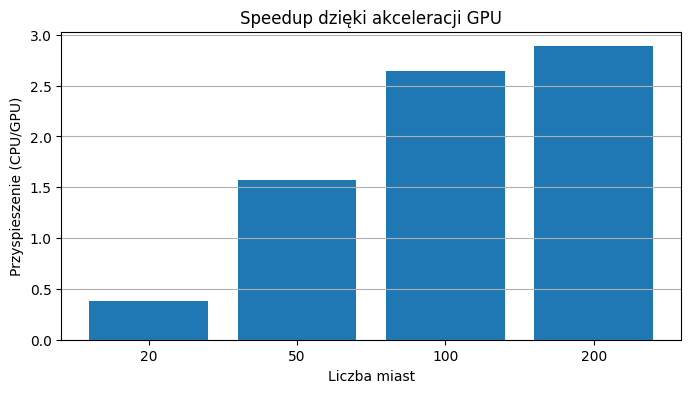

In [4]:
import math
import random
import time
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt


def generate_cities(n, seed=None):
    if seed is not None:
        random.seed(seed)
    cities = np.random.randint(0, 1000, size=(n, 2)).astype(np.float32)
    return cities

def build_distance_matrix(cities):
    # cities: numpy array (n, 2)
    n = cities.shape[0]
    dist = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        for j in range(i+1, n):
            d = np.linalg.norm(cities[i] - cities[j])
            dist[i, j] = d
            dist[j, i] = d
    return dist

# gpu
def distance_matrix_to_gpu(dist_np):
    return cp.asarray(dist_np)
# gpu tez
def route_lengths_gpu(population, dist_gpu):
    pop_array = cp.array(population, dtype=cp.int32)
    n_cities = pop_array.shape[1]

    idx_from = pop_array
    idx_to = cp.roll(pop_array, -1, axis=1)

    dists = dist_gpu[idx_from, idx_to]

    lengths = cp.sum(dists, axis=1)
    return lengths


# juz nie gpu
def random_route(n):
    r = list(range(n))
    random.shuffle(r)
    return r

def tournament_selection(population, fitness, k=3):
    pop_size = len(population)
    selected = []
    for _ in range(2):
        candidates = random.sample(range(pop_size), k)
        best = min(candidates, key=lambda idx: fitness[idx])
        selected.append(population[best])
    return selected[0], selected[1]

def pmx(p1, p2):
    n = len(p1)
    a, b = sorted([random.randint(0, n-1), random.randint(0, n-1)])
    if a == b:
        return p1[:]
    child = [-1] * n
    child[a:b] = p1[a:b]
    child_set = set(child[a:b])
    for i in range(n):
        if child[i] == -1:
            val = p2[i]
            while val in child_set:
                idx_in_p1 = p1.index(val)
                val = p2[idx_in_p1]
            child[i] = val
            child_set.add(val)
    return child

def mutate(route, prob=0.1):
    if random.random() < prob:
        i, j = random.sample(range(len(route)), 2)
        route[i], route[j] = route[j], route[i]

# główna fukncja
def genetic_tsp_gpu(num_cities=50, pop_size=100, generations=200):
    # 1. Przygotowanie danych
    cities_cpu = generate_cities(num_cities)
    dist_cpu = build_distance_matrix(cities_cpu)
    dist_gpu = distance_matrix_to_gpu(dist_cpu)

    # 2. Inicjalizacja populacji
    population = [random_route(num_cities) for _ in range(pop_size)]
    best_route = None
    best_fitness = float('inf')
    history = []

    for gen in range(generations):
        # 3. Ewaluacja
        fitness_gpu = route_lengths_gpu(population, dist_gpu)
        fitness_cpu = cp.asnumpy(fitness_gpu)

        # 4. Aktualizacja najlepszego rozwiązania
        min_idx = np.argmin(fitness_cpu)
        if fitness_cpu[min_idx] < best_fitness:
            best_fitness = fitness_cpu[min_idx]
            best_route = population[min_idx]

        history.append(best_fitness)

        if gen % 20 == 0:
            print(f"Pokolenie {gen}, najlepszy dystans: {best_fitness:.2f}")

        # 5. Tworzenie nowej populacji
        new_population = []
        new_population.append(best_route[:])

        while len(new_population) < pop_size:
            p1, p2 = tournament_selection(population, fitness_cpu, k=3)
            child = pmx(p1, p2)
            mutate(child, prob=0.15)
            new_population.append(child)

        population = new_population

    return best_route, best_fitness, history, cities_cpu

# Analiza
def performance_analysis_gpu():
    sizes = [20, 50, 100, 200]
    times_cpu = []
    times_gpu = []

    for size in sizes:
        print(f"\n Rozmiar problemu: {size} miast ")

        # Przygotowanie danych
        cities = generate_cities(size)
        dist_cpu = build_distance_matrix(cities)
        dist_gpu = distance_matrix_to_gpu(dist_cpu)

        # Test CPU (numpy)
        population = [random_route(size) for _ in range(100)]
        start = time.time()
        for route in population:
            length = 0
            for i in range(size):
                length += dist_cpu[route[i], route[(i+1)%size]]
        time_cpu = time.time() - start
        times_cpu.append(time_cpu)

        # Test GPU (CuPy)
        start = time.time()
        fitness_gpu = route_lengths_gpu(population, dist_gpu)
        cp.cuda.Stream.null.synchronize()  # synchronizacja GPU
        time_gpu = time.time() - start
        times_gpu.append(time_gpu)

        print(f"CPU: {time_cpu:.4f} s, GPU: {time_gpu:.4f} s, speedup: {time_cpu/time_gpu:.2f}x")

    # Wykres
    plt.figure(figsize=(10, 5))
    plt.plot(sizes, times_cpu, 'o-', label='CPU (numpy)')
    plt.plot(sizes, times_gpu, 's-', label='GPU (CuPy)')
    plt.xlabel('Liczba miast')
    plt.ylabel('Czas ewaluacji 100 tras [s]')
    plt.title('Porównanie wydajności CPU vs GPU')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Wykres przyspieszenia
    plt.figure(figsize=(8, 4))
    speedup = np.array(times_cpu) / np.array(times_gpu)
    plt.bar(range(len(sizes)), speedup)
    plt.xticks(range(len(sizes)), [str(s) for s in sizes])
    plt.xlabel('Liczba miast')
    plt.ylabel('Przyspieszenie (CPU/GPU)')
    plt.title('Speedup dzięki akceleracji GPU')
    plt.grid(True, axis='y')
    plt.show()

if __name__ == '__main__':
    # Sprawdzenie czy GPU jest dostępne
    print("Liczba dostępnych GPU:", cp.cuda.runtime.getDeviceCount())

    # Głowny algorytm
    print("\n Uruchamianie GA z akceleracją GPU ")
    best_route, best_fitness, history, cities = genetic_tsp_gpu(
        num_cities=80,
        pop_size=150,
        generations=300
    )

    print(f"\nNajlepsza znaleziona trasa (pierwsze 10 miast): {best_route[:10]}...")
    print(f"Dystans: {best_fitness:.2f}")

    # Wykres zbieżności
    plt.figure(figsize=(10, 4))
    plt.plot(history)
    plt.xlabel('Pokolenie')
    plt.ylabel('Najlepszy dystans')
    plt.title('Zbieżność algorytmu genetycznego (akceleracja GPU)')
    plt.grid(True)
    plt.show()

    # Analiza wydajności
    print("\n Analiza wydajności CPU vs GPU")
    performance_analysis_gpu()

54321